# 工作流程
* 載入需要的套件
* 從COCO的驗證資料集中找一張範例照片，並且網上下載，顯示照片
* 進行物件偵測，做方框標記
* 列出偵測出來的類別代碼，以及方框座標
* 列出代碼對應的物件
* 顯示辨識出來的圖形
* 展示骨骼標記
* 展示全景分割

In [ ]:
# install dependencies: #安裝依賴項
!pip install pyyaml==5.1 pycocotools>=2.0.1
#yaml類似於XML，但是語法比XML簡單得多，pyymal是yaml的Python實現，使用5.1版本
#pycocotools是coco檢測辨識的API
import torch, torchvision #import(匯入模組) torch(深度學習框架)，torchvision(是一個和torch配合使用的Python包，提供了幾個常用數據集)
print(torch.__version__, torch.cuda.is_available()) #輸出(可查看torch的版本,可查看電腦的GPU能否被PyTorch調用，結果顯示True或False)
!gcc --version #安裝GCC編譯器
# opencv is pre-installed on colab (opencv已預先安裝在colab上)

1.6.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.6)
#detectron2是FB提供的Python API，基於同樣屬於Facebook研發的PyTorch框架，使用起來相當方便。讓用戶可以在很短的時間內就完成語義分割（語意分割）的任務
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
assert torch.__version__.startswith("1.6")
#Python中assert語句通常用來對程式碼進行必要的檢查，確定某種情況一定發生，或者一定不會發生，檢查是不是1.6
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html
# -f, --find-links <url>，解析該html文件以獲取安裝

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html
     |████████████████████████████████| 6.6MB 4.4MB/s 
     |████████████████████████████████| 2.2MB 10.7MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.2.post20201020-cp36-none-any.whl size=44210 sha256=a94d841138fccea1cf2408ad0cf33052e7e46ee5ef96d1f0ddeac580032290f0
  Stored in directory: /root/.cache/pip/wheels/71/6c/b5/198f89a5c5f127327730248cc623e5a307ad11ed287c3fe391
Successfully built fvcore
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 7.0.0
    Uninstalling Pillow-7.0.0:
      Successfully uninstalled Pillow-7.0.0


In [ ]:
import detectron2
import cv2 #CV2是OpenCV官方的一個擴充庫
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from matplotlib import pyplot as plt #matplotlib是一個專業繪圖的庫，用matplotlib包的pyplot模塊繪圖

--2020-10-27 05:23:55--  https://pic.pimg.tw/crota0706/190a00702645578e08c76761f921022a.jpg
Resolving pic.pimg.tw (pic.pimg.tw)... 96.16.172.155
Connecting to pic.pimg.tw (pic.pimg.tw)|96.16.172.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 122719 (120K) [image/jpeg]
Saving to: ‘input.jpg’

input.jpg           100%[===================>] 119.84K   750KB/s    in 0.2s    

2020-10-27 05:23:55 (750 KB/s) - ‘input.jpg’ saved [122719/122719]



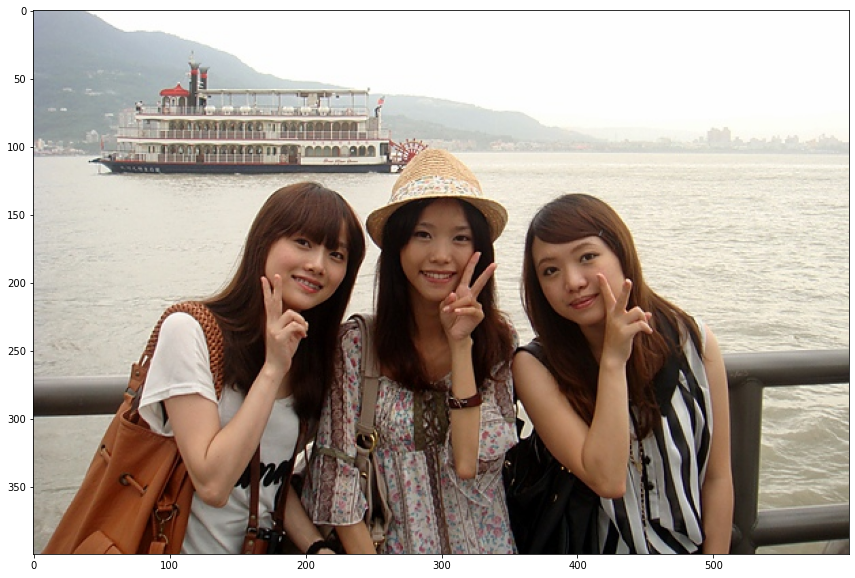

In [ ]:
!wget https://pic.pimg.tw/crota0706/190a00702645578e08c76761f921022a.jpg -O input.jpg
#!wget http://images.cocodataset.org/val2017/000000398742.jpg -O input.jpg  #下載這個照片 -O 取代成為input.jpg
im = cv2.imread("./input.jpg")  # im= cv2讀取input.jpg
plt.figure(figsize=(20,10))  #創建一個尺寸這樣的窗口
plt.imshow(im[:,:,::-1]) #繪製顯示im這張照片，

# 程式流程
* 宣告設定檔物件
* 取得設定檔，指定需要的模型種類
* 設定辨識值的門檻
* 下載模型
* 宣告偵測器，並且進行偵測
* 展示類別代碼及標記值
* 利用內建Visualizer將偵測出的圖形顯示出來

In [ ]:
# Inference with a object detection model 推論物體檢測模型
cfg = get_cfg() #獲取已經配置好默認參數的cfg
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
#config_file是指定的yaml配置文件，通過merge_from_file這個函數會將yaml文件中指定的超參數對默認值進行覆蓋。
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")

# If your detectron2's version is not the most updated, please use direct link as followed, to get the link , please visit 
# https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md

# cfg.MODEL.WEIGHTS = "https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_50_FPN_3x/137849458/model_final_280758.pkl"

predictor = DefaultPredictor(cfg)
outputs = predictor(im)


model_final_280758.pkl: 167MB [00:03, 55.2MB/s]                           
/usr/local/lib/python3.6/dist-packages/detectron2/layers/wrappers.py:226: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  return x.nonzero().unbind(1)


In [ ]:
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([ 0,  0,  0,  8, 26, 26, 26, 67], device='cuda:0')
Boxes(tensor([[347.2402, 134.1148, 519.0645, 399.5551],
        [216.0631, 100.1461, 360.8828, 398.3700],
        [ 60.4857, 125.9225, 248.7595, 397.3173],
        [ 43.1134,  33.0212, 271.3110, 122.4872],
        [ 12.4885, 205.4211, 122.9206, 400.0000],
        [344.8542, 259.9978, 442.0553, 395.2030],
        [197.4469, 225.1748, 254.9311, 385.3672],
        [315.1692, 177.2233, 330.9177, 205.9820]], device='cuda:0'))


In [ ]:
all_things = MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).thing_classes
preds = [all_things[x] for x in outputs["instances"].pred_classes]
preds

['person',
 'person',
 'person',
 'boat',
 'handbag',
 'handbag',
 'handbag',
 'cell phone']

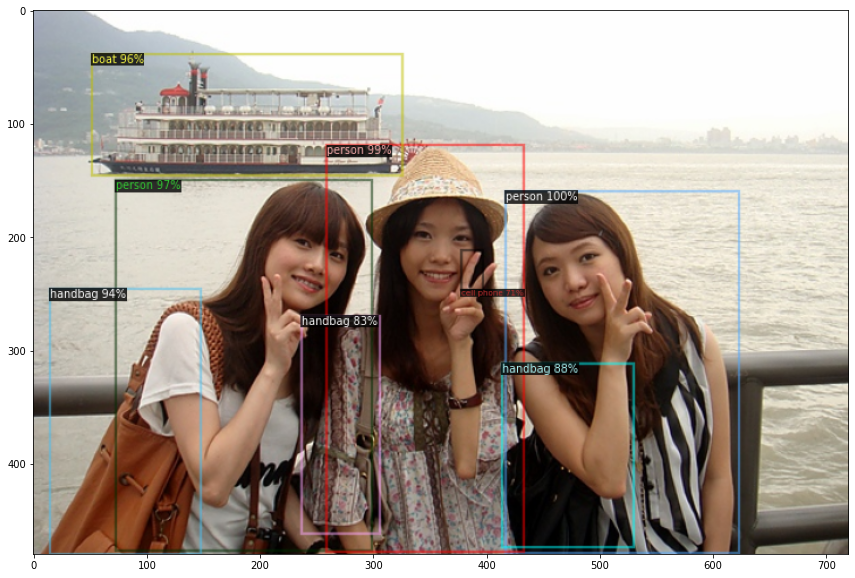

In [ ]:
v = Visualizer(im[:,:,::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize=(20,10))
plt.imshow(v.get_image())

model_final_f10217.pkl: 178MB [00:15, 11.1MB/s]                           


['person', 'person', 'person', 'boat', 'handbag', 'handbag', 'handbag', 'cell phone']


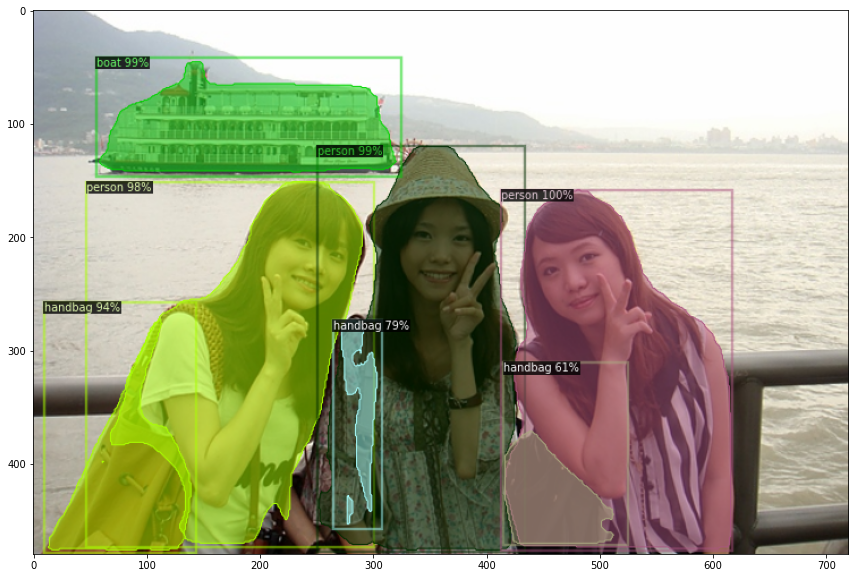

In [ ]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
#cfg.MODEL.WEIGHTS = './model_final_f10217.pkl'
predictor = DefaultPredictor(cfg)
all_things = MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).thing_classes
preds = [all_things[x] for x in outputs["instances"].pred_classes]
print(preds)
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize=(20,10))
plt.imshow(v.get_image())

model_final_a6e10b.pkl: 237MB [00:02, 84.4MB/s]                           


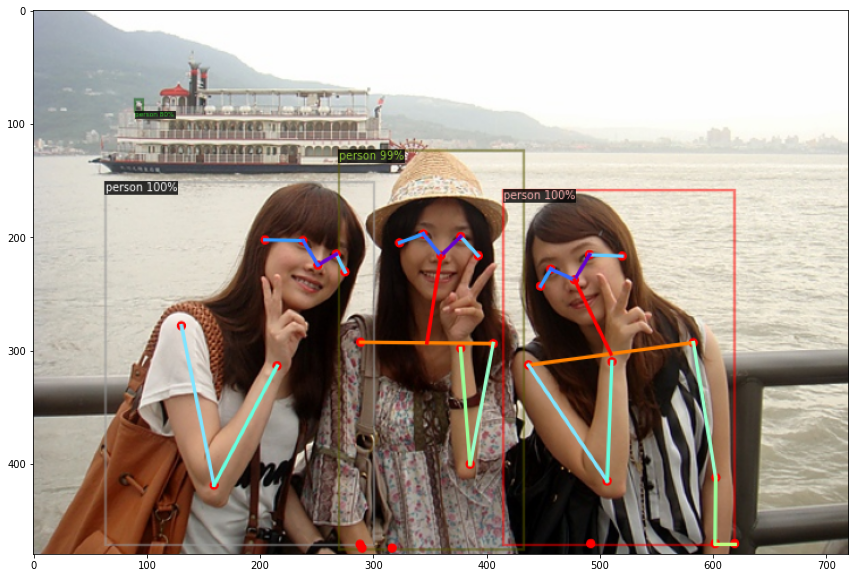

In [ ]:
# Inference with a keypoint detection model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)
v = Visualizer(im[:,:,::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize=(20,10))
plt.imshow(v.get_image())

model_final_cafdb1.pkl: 261MB [00:03, 73.6MB/s]                           


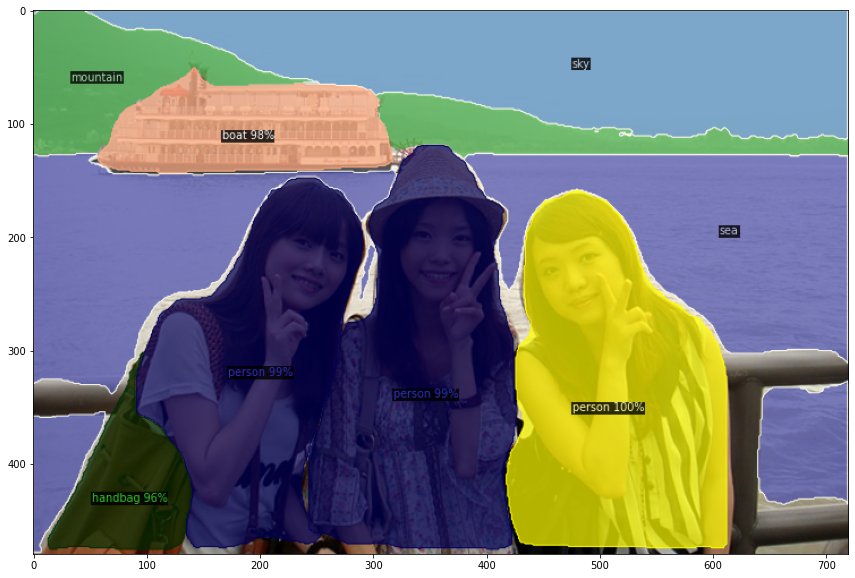

In [ ]:
# Inference with a panoptic segmentation model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
predictor = DefaultPredictor(cfg)
panoptic_seg, segments_info = predictor(im)["panoptic_seg"]
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
plt.figure(figsize=(20,10))
plt.imshow(v.get_image())